# Bibliotek

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

# Funksjoner

In [188]:
def calculate_chlorophyll_a(reflectance_data):
    a = 25.28
    b = 14.85
    c = -15.18
    
    # Extract all columns that start with 'reflectance_'
    reflectance_columns = [col for col in reflectance_data.columns if col.startswith('reflectance')]
    
    # Initialize a dictionary to store the results
    chlorophyll_a_results = {}
    
    for col in reflectance_columns:
        # Extract reflectance values at the specific wavelengths
        Rrs_709 = reflectance_data.loc[reflectance_data['lambda'] == 709, col].values
        Rrs_665 = reflectance_data.loc[reflectance_data['lambda'] == 665, col].values

        # Ensure we have the reflectance values
        if Rrs_709.size > 0 and Rrs_665.size > 0:
            Rrs_709_value = Rrs_709[0]
            Rrs_665_value = Rrs_665[0]
            
            # Calculate Chl-a using the given empirical formula
            Chl_a = a * (Rrs_709_value / Rrs_665_value) ** 2 + b * (Rrs_709_value / Rrs_665_value) + c
            chlorophyll_a_results[col] = Chl_a
        else:
            print(f"Reflectance values for 709 nm or 665 nm are not available in column {col}.")
            chlorophyll_a_results[col] = None
    
    return chlorophyll_a_results


def parse_uvspec_output(filename):
    
    data = np.loadtxt(filename)
    data = pd.DataFrame(data, columns=['lambda', 'edir', 'edn', 'eup' , 'uavgdir', 'uavgdn', 'uavgup'])

    return data


def parse_uvspec_output_umu(filename):
    """
    Parse the uvspec output for the specified format with umu data for each wavelength
    and return the data as a pandas DataFrame.

    Parameters:
    - filename: Path to the uvspec output file.

    Returns:
    - df: A pandas DataFrame containing the parsed data.
    """
    data = {
        'lambda': [],
        'edir': [],
        'edn': [],
        'eup': [],
        'uavgdir': [],
        'uavgdn': [],
        'uavgup': [],
        'umu_data': []
    }
    
    current_lambda = None
    umu_data = {}

    with open(filename, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            parts = line.strip().split()

            if not parts:
                continue

            if len(parts) == 7:
                # Wavelength block
                if current_lambda is not None:
                    data['umu_data'].append(umu_data)
                current_lambda = float(parts[0])
                data['lambda'].append(current_lambda)
                data['edir'].append(float(parts[1]))
                data['edn'].append(float(parts[2]))
                data['eup'].append(float(parts[3]))
                data['uavgdir'].append(float(parts[4]))
                data['uavgdn'].append(float(parts[5]))
                data['uavgup'].append(float(parts[6]))
                umu_data = {}

            elif len(parts) == 2 and current_lambda is not None:
                # umu and its corresponding values
                umu = float(parts[0])
                u0u = float(parts[1])
                umu_data[umu] = u0u

        if current_lambda is not None:
            data['umu_data'].append(umu_data)

    # Convert the parsed data into a pandas DataFrame
    df = pd.DataFrame({
        'lambda': data['lambda'],
        'edir': data['edir'],
        'edn': data['edn'],
        'eup': data['eup'],
        'uavgdir': data['uavgdir'],
        'uavgdn': data['uavgdn'],
        'uavgup': data['uavgup']
    })

    # Add umu columns dynamically
    for i, umu_dict in enumerate(data['umu_data']):
        for umu, u0u in umu_dict.items():
            df.at[i, f'umu({umu})'] = umu
            df.at[i, f'u0u({umu})'] = u0u

    return df


def parse_uvspec_output_umu_phi(filename):
    """
    Parse the uvspec output for the specified format with umu and phi data for each wavelength
    and return the data as a pandas DataFrame.

    Parameters:
    - filename: Path to the uvspec output file.

    Returns:
    - df: A pandas DataFrame containing the parsed data.
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store data
    wavelengths = []
    edir = []
    edn = []
    eup = []
    uavgdir = []
    uavgdn = []
    uavgup = []
    phi_values = []
    umu_data = []

    current_umu_data = []

    for line in lines:
        parts = line.strip().split()

        if len(parts) == 7:
            # Wavelength block
            if current_umu_data:
                umu_data.append(current_umu_data)
                current_umu_data = []
            wavelengths.append(float(parts[0]))
            edir.append(float(parts[1]))
            edn.append(float(parts[2]))
            eup.append(float(parts[3]))
            uavgdir.append(float(parts[4]))
            uavgdn.append(float(parts[5]))
            uavgup.append(float(parts[6]))

        elif len(parts) > 1 and all(part.replace('.', '', 1).isdigit() for part in parts):
            # Phi values
            phi_values = list(map(float, parts))

        elif len(parts) > 2:
            # Umu and its corresponding values
            umu = float(parts[0])
            u0u = float(parts[1])
            uu_values = list(map(float, parts[2:]))
            current_umu_data.append([umu, u0u] + uu_values)

    if current_umu_data:
        umu_data.append(current_umu_data)

    # Create DataFrame
    columns = ['lambda', 'edir', 'edn', 'eup', 'uavgdir', 'uavgdn', 'uavgup']
    for umu in umu_data[0]:
        columns.append(f'umu({umu[0]})')
        columns.append(f'u0u({umu[0]})')
        for phi in phi_values:
            columns.append(f'uu({umu[0]},{phi})')

    data = []
    for i in range(len(wavelengths)):
        row = [wavelengths[i], edir[i], edn[i], eup[i], uavgdir[i], uavgdn[i], uavgup[i]]
        for umu in umu_data[i]:
            row.extend(umu)
        data.append(row)

    # Ensure the number of columns matches the data
    max_columns = max(len(row) for row in data)
    for row in data:
        while len(row) < max_columns:
            row.append(None)

    # Adjust columns to match the maximum number of columns
    while len(columns) < max_columns:
        columns.append(f'unknown_col_{len(columns)}')

    df = pd.DataFrame(data, columns=columns)

    df = df.loc[:, ~df.columns.str.startswith('umu(')]

    return df

def BlackBody(w,T) :
    h = 6.62606957e-34 # joule·s 
    c = 2.99792458e8 # Speed of light in m/s 
    k = 1.38e-23 # Boltzmann constant in m^2 kg / s^2 / K  
    intensity = (2*h*c**2/w**5)*(1/(np.exp((h*c)/(w*k*T))- 1))*10**3 # in mW/m^2/nm/sr
    return intensity

def BlackBodySun(w,T,R_sun_earth=149600000):
    R_sun=696340 
    return BlackBody(w,T)*(R_sun/R_sun_earth)**2*1.0e-9*np.pi

# Scenario 1 - Clean Sky

  Altitude      Chl-a
0      0 m  24.305230
1    120 m  24.316156
2   100 km  24.950015


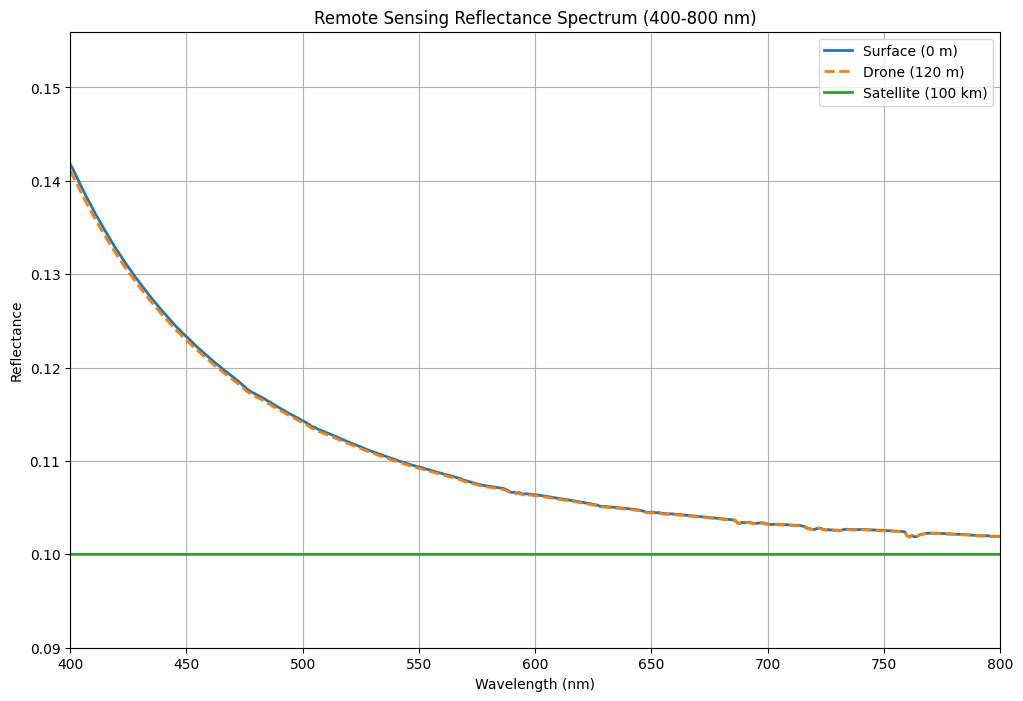

In [189]:
# load data
SC1_0m = parse_uvspec_output('Data/SC1_0m.OUT')
SC1_0m['reflectance'] = SC1_0m['eup'] / SC1_0m['edir'] 

SC1_120m = parse_uvspec_output('Data/SC1_120m.OUT')
SC1_120m['reflectance'] = SC1_120m['eup'] / SC1_120m['edir']

SC1_TOA = parse_uvspec_output('Data/SC1_TOA.OUT')
SC1_TOA['reflectance'] = SC1_TOA['eup'] / SC1_TOA['edir']

# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC1_0m)
chl_a_120m = calculate_chlorophyll_a(SC1_120m)
chl_a_TOA = calculate_chlorophyll_a(SC1_TOA)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', '100 km'],
    'Chl-a': [chl_a_0m.get('reflectance'), chl_a_120m.get('reflectance'), chl_a_TOA.get('reflectance')]
})

print(chl_df)

# Plot reflectance spectra
plt.figure(figsize=(12, 8))
plt.plot(SC1_0m['lambda'], SC1_0m['reflectance'], label='Surface (0 m)', linewidth=2)
plt.plot(SC1_120m['lambda'], SC1_120m['reflectance'], label='Drone (120 m)' , linewidth=2, linestyle='--')
plt.plot(SC1_TOA['lambda'], SC1_TOA['reflectance'], label='Satellite (100 km)' , linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Remote Sensing Reflectance Spectrum (400-800 nm)')
plt.legend()

plt.xlim(400, 800)
plt.ylim(
    min(SC1_0m['reflectance'].min(), SC1_120m['reflectance'].min(), SC1_TOA['reflectance'].min())*0.9,
    max(SC1_0m['reflectance'].max(), SC1_120m['reflectance'].max(), SC1_TOA['reflectance'].max()) * 1.1
)
plt.grid(True)
plt.show()

# Scenario 2 - Clean Sky

  Altitude  Chl-a (0° azimuth)  Chl-a (90° azimuth)
0      0 m           24.300329            24.300329
1    120 m           24.311580            24.311580
2   100 km           24.950009            24.950009


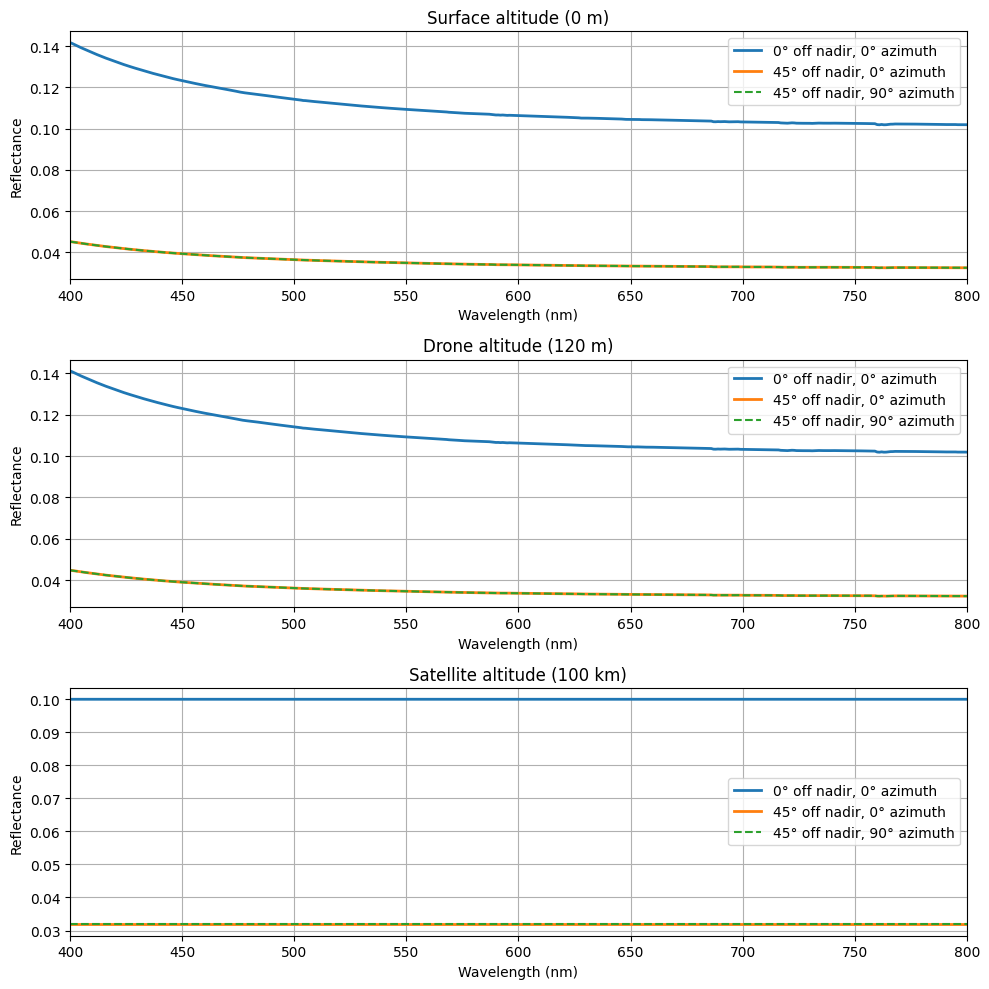

In [190]:
SC2_0m = parse_uvspec_output_umu_phi('Data/SC2_0m.OUT')
SC2_0m['reflectance0'] = SC2_0m['uu(0.7071,0.0)'] / SC2_0m['edir']
SC2_0m['reflectance90'] = SC2_0m['uu(0.7071,90.0)'] / SC2_0m['edir']

SC2_120m = parse_uvspec_output_umu_phi('Data/SC2_120m.OUT')
SC2_120m['reflectance0'] = SC2_120m['uu(0.7071,0.0)'] / SC2_120m['edir']
SC2_120m['reflectance90'] = SC2_120m['uu(0.7071,90.0)'] / SC2_120m['edir']

SC2_TOA = parse_uvspec_output_umu_phi('Data/SC2_TOA.OUT')
SC2_TOA['reflectance0'] = SC2_TOA['uu(0.7071,0.0)'] / SC2_TOA['edir']
SC2_TOA['reflectance90'] = SC2_TOA['uu(0.7071,90.0)'] / SC2_TOA['edir']


# calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC2_0m)
chl_a_120m = calculate_chlorophyll_a(SC2_120m)
chl_a_TOA = calculate_chlorophyll_a(SC2_TOA)

chl_a_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', '100 km'],
    'Chl-a (0° azimuth)': [chl_a_0m.get('reflectance0'), chl_a_120m.get('reflectance0'), chl_a_TOA.get('reflectance0')],
    'Chl-a (90° azimuth)': [chl_a_0m.get('reflectance90'), chl_a_120m.get('reflectance90'), chl_a_TOA.get('reflectance90')]
})

print(chl_a_df)


fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].plot(SC1_0m['lambda'], SC1_0m['reflectance'], label='0° off nadir, 0° azimuth', linewidth=2)
ax[0].plot(SC2_0m['lambda'], SC2_0m['reflectance0'], label='45° off nadir, 0° azimuth', linewidth=2)
ax[0].plot(SC2_0m['lambda'], SC2_0m['reflectance90'], label='45° off nadir, 90° azimuth', linewidth=1.5, linestyle='--')
ax[0].set_title('Surface altitude (0 m)')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_ylabel('Reflectance')
ax[0].legend()
ax[0].set_xlim(400, 800)
ax[0].grid(True)

ax[1].plot(SC1_120m['lambda'], SC1_120m['reflectance'], label='0° off nadir, 0° azimuth', linewidth=2)
ax[1].plot(SC2_120m['lambda'], SC2_120m['reflectance0'], label='45° off nadir, 0° azimuth', linewidth=2)
ax[1].plot(SC2_120m['lambda'], SC2_120m['reflectance90'], label='45° off nadir, 90° azimuth', linewidth=1.5, linestyle='--')
ax[1].set_title('Drone altitude (120 m)')
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('Reflectance')
ax[1].legend()
ax[1].set_xlim(400, 800)
ax[1].grid(True)

ax[2].plot(SC1_TOA['lambda'], SC1_TOA['reflectance'], label='0° off nadir, 0° azimuth', linewidth=2)
ax[2].plot(SC2_TOA['lambda'], SC2_TOA['reflectance0'], label='45° off nadir, 0° azimuth', linewidth=2)
ax[2].plot(SC2_TOA['lambda'], SC2_TOA['reflectance90'], label='45° off nadir, 90° azimuth', linewidth=1.5, linestyle='--')   
ax[2].set_title('Satellite altitude (100 km)')
ax[2].set_xlabel('Wavelength (nm)')
ax[2].set_ylabel('Reflectance')
ax[2].legend()
ax[2].set_xlim(400, 800)
ax[2].grid(True)

plt.tight_layout()

plt.show()

# Scenario 3 - Oceanic Aerosols

  Altitude      Chl-a
0      0 m  23.101492
1    120 m  23.081635
2   100 km  23.618051


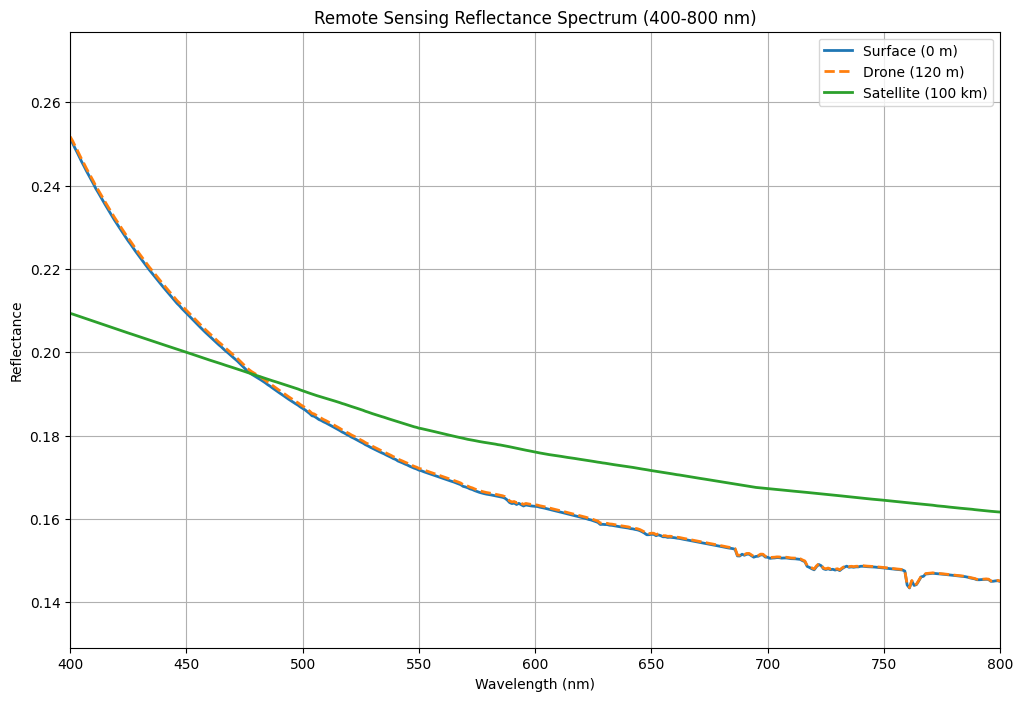

In [191]:
SC3_0m = parse_uvspec_output('Data/SC3_0m.OUT')
SC3_0m['reflectance'] = SC3_0m['eup'] / SC3_0m['edir']

SC3_120m = parse_uvspec_output('Data/SC3_120m.OUT')
SC3_120m['reflectance'] = SC3_120m['eup'] / SC3_120m['edir']

SC3_TOA = parse_uvspec_output('Data/SC3_TOA.OUT')
SC3_TOA['reflectance'] = SC3_TOA['eup'] / SC3_TOA['edir']

# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC3_0m)
chl_a_120m = calculate_chlorophyll_a(SC3_120m)
chl_a_TOA = calculate_chlorophyll_a(SC3_TOA)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', '100 km'],
    'Chl-a': [chl_a_0m.get('reflectance'), chl_a_120m.get('reflectance'), chl_a_TOA.get('reflectance')]
})

print(chl_df)

# Plot reflectance spectra
plt.figure(figsize=(12, 8))
plt.plot(SC3_0m['lambda'], SC3_0m['reflectance'], label='Surface (0 m)', linewidth=2)
plt.plot(SC3_120m['lambda'], SC3_120m['reflectance'], label='Drone (120 m)' , linewidth=2 , linestyle='--')
plt.plot(SC3_TOA['lambda'], SC3_TOA['reflectance'], label='Satellite (100 km)' , linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Remote Sensing Reflectance Spectrum (400-800 nm)')
plt.legend()

plt.xlim(400, 800)
plt.ylim(
    min(SC3_0m['reflectance'].min(), SC3_120m['reflectance'].min(), SC3_TOA['reflectance'].min())*0.9,
    max(SC3_0m['reflectance'].max(), SC3_120m['reflectance'].max(), SC3_TOA['reflectance'].max()) * 1.1
)
plt.grid(True)
plt.show()

# Scenario 4 - Adjacency Effects

  Altitude       Chl-a
0      0 m  439.412496
1    120 m  439.165296
2   100 km  446.975654


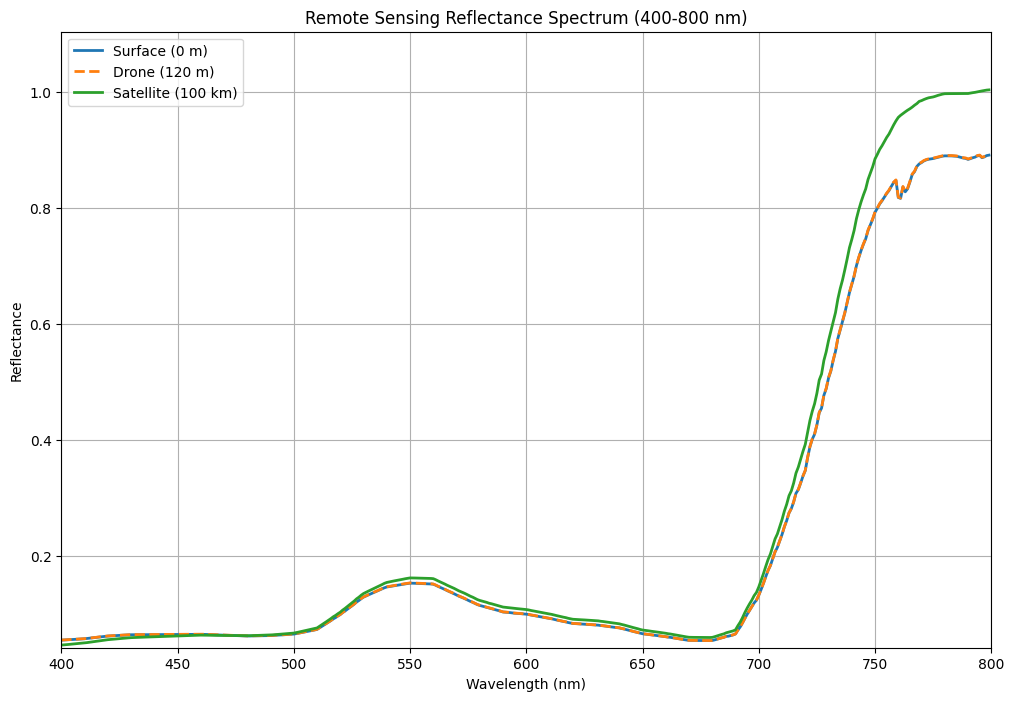

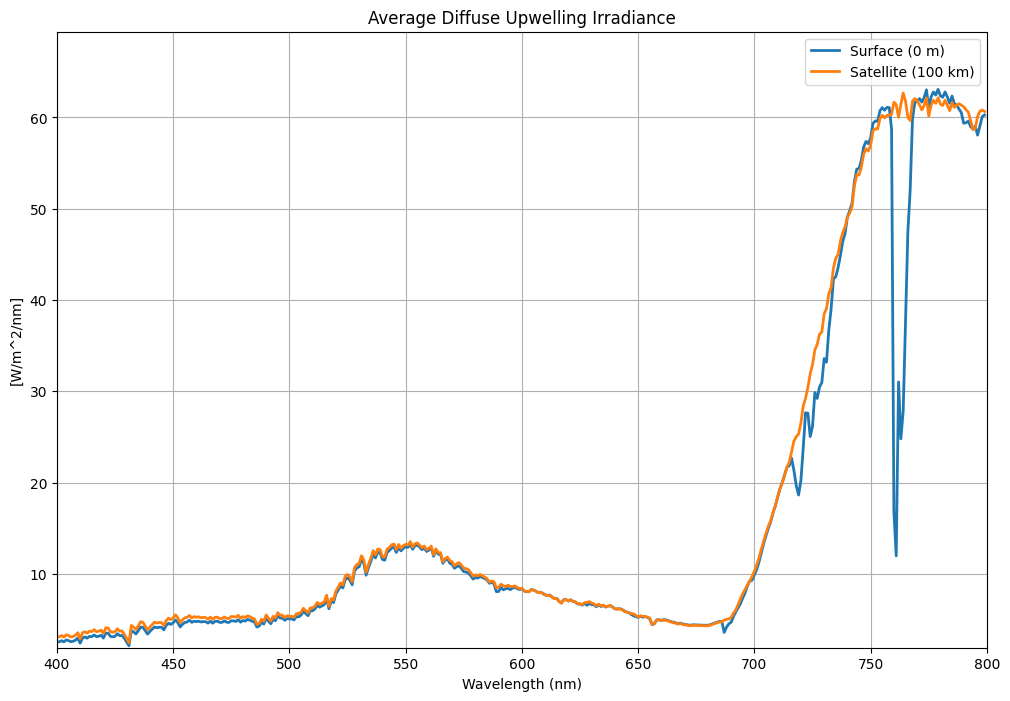

In [192]:
SC4_0m = parse_uvspec_output('Data/SC4_0m.OUT')
SC4_0m['reflectance'] = SC4_0m['eup'] / SC4_0m['edir']

SC4_120m = parse_uvspec_output('Data/SC4_120m.OUT')
SC4_120m['reflectance'] = SC4_120m['eup'] / SC4_120m['edir']

SC4_TOA = parse_uvspec_output('Data/SC4_TOA.OUT')
SC4_TOA['reflectance'] = SC4_TOA['eup'] / SC4_TOA['edir']

# Calculate Chl-a for each dataset
chl_a_0m = calculate_chlorophyll_a(SC4_0m)
chl_a_120m = calculate_chlorophyll_a(SC4_120m)
chl_a_TOA = calculate_chlorophyll_a(SC4_TOA)

chl_df = pd.DataFrame({
    'Altitude': ['0 m', '120 m', '100 km'],
    'Chl-a': [chl_a_0m.get('reflectance'), chl_a_120m.get('reflectance'), chl_a_TOA.get('reflectance')]
})

print(chl_df)

# Plot reflectance spectra
plt.figure(figsize=(12, 8))
plt.plot(SC4_0m['lambda'], SC4_0m['reflectance'], label='Surface (0 m)', linewidth=2)
plt.plot(SC4_120m['lambda'], SC4_120m['reflectance'], label='Drone (120 m)' , linewidth=2 , linestyle='--')
plt.plot(SC4_TOA['lambda'], SC4_TOA['reflectance'], label='Satellite (100 km)' , linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Remote Sensing Reflectance Spectrum (400-800 nm)')
plt.legend()

plt.xlim(400, 800)
plt.ylim(
    min(SC4_0m['reflectance'].min(), SC4_120m['reflectance'].min(), SC4_TOA['reflectance'].min())*0.9,
    max(SC4_0m['reflectance'].max(), SC4_120m['reflectance'].max(), SC4_TOA['reflectance'].max()) * 1.1
)
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(SC4_0m['lambda'], SC4_0m['uavgup'], label='Surface (0 m)', linewidth=2)
plt.plot(SC4_TOA['lambda'], SC4_TOA['uavgup'], label='Satellite (100 km)' , linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('[W/m^2/nm]')
plt.title('Average Diffuse Upwelling Irradiance')
plt.legend()

plt.xlim(400, 800)
plt.ylim(
    min(SC4_0m['uavgup'].min(), SC4_120m['uavgup'].min(), SC4_TOA['uavgup'].min())*0.9,
    max(SC4_0m['uavgup'].max(), SC4_120m['uavgup'].max(), SC4_TOA['uavgup'].max()) * 1.1
)
plt.grid(True)
plt.show()

# Lekeplass

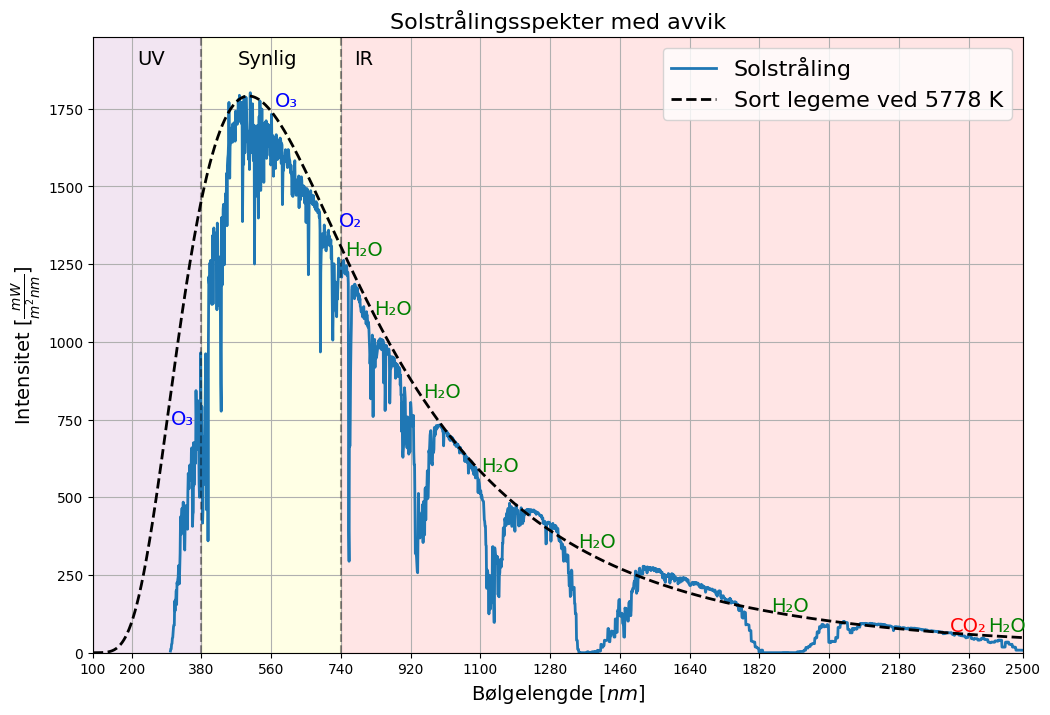

In [193]:
# Load solar spectrum data
solar = np.loadtxt('Data/solar.dat')

# Black Body Radiation (BB)
BBwave = np.arange(100, 2500, 1)
BB = BlackBodySun(BBwave * 10**(-9), 5778)

# Plot solar spectrum
plt.figure(figsize=(12, 8))
plt.plot(solar[:, 0], solar[:, 1], linewidth=2, label='Solstråling')
plt.plot(BBwave, BB, color='k', linestyle='--', linewidth=2, label='Sort legeme ved 5778 K')

# Annotate regions UV, Visible, and Infrared
plt.axvspan(100, 380, color='purple', alpha=0.1)  # UV region
plt.axvspan(380, 740, color='yellow', alpha=0.1)  # Visible region
plt.axvspan(740, 2500, color='red', alpha=0.1)    # Infrared region
plt.axvline(x=380, color='k', linestyle='--', alpha=0.4)
plt.axvline(x=740, color='k', linestyle='--', alpha=0.4)

plt.text(250, max(solar[:, 1]) * 1.05, 'UV', fontsize=14, ha='center')
plt.text(550, max(solar[:, 1]) * 1.05, 'Synlig', fontsize=14, ha='center')
plt.text(800, max(solar[:, 1]) * 1.05, 'IR', fontsize=14, ha='center')

# Annotate known absorption regions for greenhouse gases
# Oxygen (O2)
plt.text(765, BB[765-150], 'O₂', color='blue', fontsize=14, ha='center')

# Ozone (O3) 
plt.text(330, BB[340-150], 'O₃', color='blue', fontsize=14, ha='center')
plt.text(600, BB[600-150], 'O₃', color='blue', fontsize=14, ha='center')

# Water vapor (H2O)
plt.text(800, BB[800-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(875, BB[875-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1000, BB[1000-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1150, BB[1150-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1400, BB[1400-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(1900, BB[1900-150], 'H₂O', color='green', fontsize=14, ha='center')
plt.text(2460, BB[2400-150]+10, 'H₂O', color='green', fontsize=14, ha='center')

# Carbon dioxide (CO2) 
plt.text(2360, BB[2400-150]+10, 'CO₂', color='red', fontsize=14, ha='center')


# Add labels and title
plt.xlabel(r'Bølgelengde [$nm$]',fontsize=14)
plt.ylabel(r'Intensitet [$\frac{mW}{m^2nm}$]',fontsize=14)
plt.title('Solstrålingsspekter med avvik',fontsize=16)
plt.ylim(0, max(solar[:, 1])*1.1)
plt.xlim(100, 2500)

ticks = np.arange(200, 2510, 180)
ticks = np.append(ticks, [100, 2500])
plt.xticks(ticks)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()
